# Urbanpy model for Para


Start date: 2022-02-09
Make sure the necessary packages are installed from the `pipenv` file created for this work.

To do this, go to the local directory for this project, and in your terminal run:

`pipenv install`

Then, activate the environment by running

`pipenv shell`

**Note**: You may need to run `brew install gdal` in terminal and then `pip install urbanpy` in this notebook to get code below to run. Issue submitted about installation difficulties [here](https://github.com/EL-BID/urbanpy/issues/18).


In [1]:
import warnings

warnings.filterwarnings("ignore")

import matplotlib.pyplot as plt

plt.rcParams["figure.figsize"] = (10, 10)

# Only needed when git cloning the urbanpy repo
# import sys
# sys.path.append('..')

import urbanpy as up
import geopandas as gpd
import numpy as np
import pandas as pd
import plotly.express as px
import os

from tqdm.notebook import tqdm

tqdm.pandas()

from pandarallel import pandarallel

cores = os.cpu_count()

# Adjust the number of workers to your setup (computer & docker)
pandarallel.initialize(progress_bar=True, nb_workers=cores)

INFO: Pandarallel will run on 10 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.


In [2]:
import h3
from shapely.geometry import Polygon

## Read Para's hexagons


In [3]:
para_hexs = pd.read_csv("outputs/29112023_para_hexs_final.csv", index_col=0)

In [4]:
para_hexs.head()

,hex,population_2020,pop_3_5_years_adj,pop_6_14_years_adj,pop_15_17_years_adj,pop_18_years_adj,V002_adj,V003_adj,income_pc,ensino_fundamental,...,AVG_QT_TUR_MED,AVG_QT_TUR_PROF,AVG_QT_TUR_PROF_TEC,AVG_QT_TUR_EJA,AVG_QT_TUR_EJA_FUND,AVG_QT_TUR_EJA_MED,AVG_QT_TUR_ESP,AVG_QT_TUR_ESP_CC,AVG_QT_TUR_ESP_CE,urban_area
0,888062d73dfffff,328.677081,464.000000,74.000000,7.000000,2.000000,1741.000000,110501.000000,63.469845,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,2.0,2.0,0.0,0
25,8880669749fffff,6.645306,0.620557,0.214808,0.031823,0.039779,6.491976,1138.092715,175.307598,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
35,888a92cb25fffff,19.246575,10.420928,4.408854,1.002012,0.200402,61.122752,14736.595316,241.098361,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
40,8881439147fffff,5.421374,0.617580,0.420769,0.067866,0.020360,4.044809,801.679859,198.199664,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
46,88806dc2b3fffff,6.842970,4.088244,1.233839,0.257817,0.073662,25.229252,2125.739460,84.256934,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0


In [5]:
para_hexs.shape

(132361, 193)

In [6]:
para_hexs.columns

Index(['hex', 'population_2020', 'pop_3_5_years_adj', 'pop_6_14_years_adj',
       'pop_15_17_years_adj', 'pop_18_years_adj', 'V002_adj', 'V003_adj',
       'income_pc', 'ensino_fundamental',
       ...
       'AVG_QT_TUR_MED', 'AVG_QT_TUR_PROF', 'AVG_QT_TUR_PROF_TEC',
       'AVG_QT_TUR_EJA', 'AVG_QT_TUR_EJA_FUND', 'AVG_QT_TUR_EJA_MED',
       'AVG_QT_TUR_ESP', 'AVG_QT_TUR_ESP_CC', 'AVG_QT_TUR_ESP_CE',
       'urban_area'],
      dtype='object', length=193)

In [7]:
%%time
# Get polygon from h3 index
para_hexs["geometry"] = para_hexs["hex"].parallel_apply(
    lambda x: Polygon(h3.h3_to_geo_boundary(x, geo_json=True))
)

CPU times: user 380 ms, sys: 107 ms, total: 487 ms
Wall time: 826 ms


In [8]:
para_hexs = gpd.GeoDataFrame(para_hexs, crs="4326")

## Visualize the population data


In [9]:
if False:
    fig = up.plotting.choropleth_map(
        para_hexs.reset_index(drop=True),
        "population_2020",
        title="Para Population - 2020",
        zoom=8,
        color_continuous_scale="Viridis",
        opacity=0.1,
        labels={"population_2020": "Pop. 2020"},
    )

    fig.update_layout(
        margin=dict(l=0, r=0, t=30, b=0),
    )
    fig.update_traces(marker_line_width=0)
    fig.show()

## Urban accessibility - import high quality school data


These data are stored in a csv file named `brazil_schools_census_education_metrics.parquet` that we need to read.


In [10]:
br_schools = gpd.read_parquet("outputs/brazil_schools_census_edu_metrics.parquet")

In [11]:
br_schools.shape

(222936, 147)

In [12]:
br_schools.head(2)

,abbrev_state,name_muni,code_school,name_school,education_level,education_level_others,admin_category,address,phone_number,government_level,...,FUN_07_CAT_0,FUN_08_CAT_0,FUN_09_CAT_0,MULT_ETA_CAT_0,MED_CAT_0,MED_01_CAT_0,MED_02_CAT_0,MED_03_CAT_0,MED_04_CAT_0,MED_NS_CAT_0
0,RO,Porto Velho,11000023,EEEE ABNAEL MACHADO DE LIMA - CENE,Ensino Fundamental,Atendimento Educacional Especializado,Pública,"AVENIDA AMAZONAS, 6492 ZONA LESTE. TIRADENTES....",(69) 992083054,Estadual,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,RO,Porto Velho,11000040,EMEIEF PEQUENOS TALENTOS,Educação Infantil,,Pública,"RUA CAETANO, 3256 PREDIO. CALADINHO. 76808-108...",(69) 32135237,Municipal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


## Subset schools

Criteria:

1. Only consider schools in Para
1. Only consider Public schools
1. Only consider schools that are active
1. Only consider schools from the level Ensino Fundamental (6 - 14 years old)


In [13]:
br_schools.columns[:15]

Index(['abbrev_state', 'name_muni', 'code_school', 'name_school',
       'education_level', 'education_level_others', 'admin_category',
       'address', 'phone_number', 'government_level', 'private_school_type',
       'private_government_partnership', 'regulated_education_council',
       'service_restriction', 'size'],
      dtype='object')

In [14]:
print(
    br_schools["admin_category"].value_counts(),
    "\n\ncount",
    br_schools["admin_category"].isna().sum(),
    "\n\n",
    br_schools["government_level"].value_counts(),
    "\n\ncount",
    br_schools["government_level"].isna().sum(),
)

admin_category
Pública    171631
Privada     51305
Name: count, dtype: int64 

count 0 

 government_level
Municipal    137311
Privada       51305
Estadual      33609
Federal         711
Name: count, dtype: int64 

count 0


In [15]:
br_schools["private_school_type"].value_counts()

private_school_type
Não Informado    180710
Particular        31988
Filantrópica       7837
Comunitária        2097
Confessional        304
Name: count, dtype: int64

In [16]:
br_schools["private_government_partnership"].value_counts()

private_government_partnership
Não    215093
Sim      7843
Name: count, dtype: int64

In [17]:
br_schools["urban"].value_counts(), br_schools["urban"].isna().sum()

(urban
 Urbana    141373
 Rural      81563
 Name: count, dtype: int64,
 0)

In [18]:
print("Unique values of abbrev_state: ")
print("Number of unique values", len(br_schools["abbrev_state"].unique()))
print(br_schools["abbrev_state"].unique())
print()

print("Unique values of service_restriction: ")
print("Number of unique values", len(br_schools["service_restriction"].unique()))
print(br_schools["service_restriction"].unique())
print()

print("Unique values of education_level: ")
print("Number of unique values", len(br_schools["education_level"].unique()))
print(br_schools["education_level"].unique())
print()

print("Unique values of admin_category: ")
print("Number of unique values", len(br_schools["admin_category"].unique()))
print(br_schools["admin_category"].unique())
print()

Unique values of abbrev_state: 
Number of unique values 27
['RO' 'AC' 'AM' 'RR' 'PA' 'AP' 'TO' 'MA' 'PI' 'CE' 'RN' 'PB' 'PE' 'AL'
 'SE' 'BA' 'MG' 'ES' 'RJ' 'SP' 'PR' 'SC' 'RS' 'MS' 'MT' 'GO' 'DF']

Unique values of service_restriction: 
Number of unique values 5
['ESCOLA ATENDE EXCLUSIVAMENTE ALUNOS COM DEFICIÊNCIA'
 'ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATENDIMENTO'
 'ESCOLA PARALISADA' 'ESCOLA EXCLUSIVA DE ATIVIDADE COMPLEMENTAR'
 'ESCOLA EXCLUSIVA DE ATENDIMENTO EDUCACIONAL ESPECIALIZADO']

Unique values of education_level: 
Number of unique values 30
['Ensino Fundamental' 'Educação Infantil'
 'Educação Infantil, Ensino Fundamental, Ensino Médio'
 'Educação Infantil, Ensino Fundamental'
 'Ensino Fundamental, Ensino Médio' ''
 'Ensino Fundamental, Educação de Jovens Adultos'
 'Ensino Fundamental, Ensino Médio, Educação de Jovens Adultos'
 'Ensino Médio'
 'Educação Infantil, Ensino Fundamental, Ensino Médio, Educação Profissional'
 'Educação de Jovens Adultos'
 'Educação Infanti

In [19]:
# Real unique values for education_levels
print("Unique values of education_level: ")
print("Number of unique values", len(para_hexs.columns[9:15]))
print(para_hexs.columns[9:15].tolist())
print()

Unique values of education_level: 
Number of unique values 6
['ensino_fundamental', 'educacao_infantil', 'ensino_medio', 'educacao_jovens_adultos', 'educacao_profissional', 'no_specified']



In [20]:
# Calculate the number of combinations the user could make

# Number of options for each variable
government_level_options = 3
urban_options = 2
education_level_options = 3

# Calculate the number of combinations for each variable
government_level_combinations = 2**government_level_options
urban_combinations = 2**urban_options
education_level_combinations = 2**education_level_options

# Calculate the total number of combinations
total_combinations = (
    government_level_combinations * urban_combinations * education_level_combinations
)

print(total_combinations)

256


In [21]:
# Create the filters
state_filter = br_schools["abbrev_state"] == "PA"
service_filter = (
    br_schools["service_restriction"]
    == "ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATENDIMENTO"
)
level_filter = br_schools["education_level"].str.contains("Ensino Fundamental")
admin_filter = br_schools["admin_category"] == "Pública"

In [22]:
# Apply the filters
filtered_schools = br_schools[
    state_filter & admin_filter & service_filter & level_filter
]

In [23]:
# Print a small report with the number of schools and percentage of the total
print(f"Total number of schools: {len(br_schools)}")
print(f"Number of schools selected: {len(filtered_schools)}")
print(f"Percentage of the total: {len(filtered_schools) / len(br_schools) * 100:.2f}%")

Total number of schools: 222936
Number of schools selected: 8582
Percentage of the total: 3.85%


## Evaluate Accessibility


In [24]:
filtered_schools["lat"] = filtered_schools.geometry.y
filtered_schools["lon"] = filtered_schools.geometry.x

In [25]:
filtered_schools.geometry.x.isna().sum()

1874

In [26]:
filtered_schools = filtered_schools.dropna(subset=["lat", "lon"])

In [27]:
# Save the clean filtered schools to a parquet file
# Change values according to the used filters
state = "para"
status = "em_funcionamento"
level = "ensino_fundamental"
admin = "publicas"
filtered_schools.to_parquet(
    f"outputs/clean_escolas_{state}_{status}_{level}_{admin}.parquet"
)

In [28]:
para_hexs["lat"] = para_hexs.geometry.centroid.y
para_hexs["lon"] = para_hexs.geometry.centroid.x

Get the nearest school from each hexagons centroid


In [ ]:
dist_up, ind_up = up.utils.nn_search(
    # These are the schools
    tree_features=filtered_schools[["lat", "lon"]].values,
    # Values are the centroids of each hexagon
    query_features=para_hexs[["lat", "lon"]].values,
    metric="haversine",
)

This adds new column to indicate the index of the closest school for a particular hexagon


In [ ]:
para_hexs["closest_school_id"] = ind_up
para_hexs["closest_school_dist"] = dist_up

## Download data needed for Para


In [ ]:
!cd ~/data/osrm && wget -nc https://download.geofabrik.de/south-america/brazil/norte-latest.osm.pbf

## Start the OSRM server


In [ ]:
# Download unix_download.sh file from github repo
!cd .env/lib/python3.11/site-packages/urbanpy/routing/ && wget -nc https://raw.githubusercontent.com/EL-BID/urbanpy/master/urbanpy/routing/unix_download.sh

In [ ]:
up.routing.start_osrm_server("norte", "south-america_brazil", "foot")

Then we can do our distance and duration calculations


In [ ]:
# Running an example route to check if the server is working
# This also fixs the Python multiprocessing error in MacOS
# (For more info see: https://github.com/nalepae/pandarallel/issues/225)

origin = para_hexs.iloc[0]
destination = filtered_schools.iloc[para_hexs.iloc[0]["closest_school_id"]]

# (distance in meters, duration in seconds)
up.routing.osrm_route(origin.geometry.centroid, destination.geometry)

In [ ]:
import time

In [ ]:
start_time = time.time()
distance_duration_para_by_foot = para_hexs.parallel_apply(
    lambda row: up.routing.osrm_route(
        origin=row.geometry.centroid,
        destination=filtered_schools.iloc[row["closest_school_id"]]["geometry"],
    ),
    result_type="expand",
    axis=1,
)
print("Elapsed time (s)", time.time() - start_time)

## Inspect results


In [ ]:
para_hexs["distance_to_school_km_by_foot"] = (
    distance_duration_para_by_foot[0] / 1000
)  # meters to kilometers
para_hexs["duration_to_school_min_by_foot"] = (
    distance_duration_para_by_foot[1] / 60
)  # seconds to minutes

In [ ]:
# Once we have finished with the OSRM server we stop it
up.routing.stop_osrm_server("norte", "south-america_brazil", "foot")

## Create map for travel times by foot to nearest schools


In [ ]:
para_hexs["duration_to_school_min_by_foot"].describe()

In [ ]:
if False:
    # Reset index is needed to avoid an error with plotly choropleth_map
    fig = up.plotting.choropleth_map(
        para_hexs.reset_index(drop=True),
        "duration_to_school_min_by_foot",
        title="Pará - Estimated travel times to school by foot",
        zoom=8,
        color_continuous_scale="Plasma_r",
        opacity=0.6,
        labels={"duration_to_school_min_by_foot": "Duration (min)"},
    )

    fig.update_layout(
        margin=dict(l=0, r=0, t=50, b=0),
    )
    fig.update_traces(marker_line_width=0)
    fig.show()

The scale of travel times is not very usefult because of range of values. We can use a more meaningful scale by binning the travel times into human readable categories.


## Making map with bins of duration


First get default categories


In [ ]:
custom_bins, custom_labels = up.utils.create_duration_labels(
    para_hexs["duration_to_school_min_by_foot"]
)
print(custom_bins)
print(custom_labels)

Then convert from numerical to categorical


In [ ]:
para_hexs["duration_to_school_min_by_foot_cat"] = pd.cut(
    para_hexs["duration_to_school_min_by_foot"], bins=custom_bins, labels=custom_labels
)

Then plot


In [ ]:
if False:
    map_figure = up.plotting.choropleth_map(
        para_hexs.reset_index(drop=True),
        "duration_to_school_min_by_foot_cat",
        zoom=8,
        opacity=0.6,
        title="Pará - Estimated travel times to school by foot",
        color_discrete_sequence=px.colors.sequential.Plasma_r,
        category_orders={"duration_to_school_min_by_foot_cat": custom_labels},
        labels={"duration_to_school_min_by_foot_cat": "Duration (minutes)"},
    )

    map_figure.update_layout(
        margin=dict(l=0, r=0, t=50, b=0),
    )
    map_figure.update_traces(marker_line_width=0)
    map_figure.show()

## Create map for travel times by car to nearest schools


In [ ]:
up.routing.start_osrm_server("norte", "south-america_brazil", "car")

In [ ]:
# # Stop all multiprocess child processes
# import multiprocessing
# active = multiprocessing.active_children()
# for child in active:
#     child.terminate()

In [ ]:
distance_duration_para_by_car = para_hexs.progress_apply(
    lambda row: up.routing.osrm_route(
        origin=row.geometry.centroid,
        destination=filtered_schools.iloc[row["closest_school_id"]]["geometry"],
    ),
    result_type="expand",
    axis=1,
)

In [ ]:
para_hexs["distance_to_school_km_by_car"] = (
    distance_duration_para_by_car[0] / 1000
)  # meters to kilometers
para_hexs["duration_to_school_min_by_car"] = (
    distance_duration_para_by_car[1] / 60
)  # seconds to minutes

In [ ]:
# Once we have finished with the OSRM server we stop it
up.routing.stop_osrm_server("norte", "south-america_brazil", "car")

## Create map for travel times by car to nearest schools


In [ ]:
para_hexs[
    [
        "distance_to_school_km_by_foot",
        "distance_to_school_km_by_car",
        "duration_to_school_min_by_foot",
        "duration_to_school_min_by_car",
    ]
].describe()

In [ ]:
if False:
    # Reset index is needed to avoid an error with plotly choropleth_map
    fig = up.plotting.choropleth_map(
        para_hexs.reset_index(drop=True),
        "duration_to_school_min_by_car",
        title="Para Estimated travel times to school by car",
        zoom=8,
        color_continuous_scale="Plasma_r",
        opacity=0.6,
        labels={"duration_to_school_min_by_car": "Duration (min)"},
    )

    fig.update_layout(
        margin=dict(l=0, r=0, t=50, b=0),
    )
    fig.update_traces(marker_line_width=0.0)
    fig.show()

## Making map with bins of duration


First get default categories


In [ ]:
custom_bins, custom_labels = up.utils.create_duration_labels(
    para_hexs["duration_to_school_min_by_car"]
)
print(custom_bins)
print(custom_labels)

Then convert from numerical to categorical


In [ ]:
para_hexs["duration_to_school_min_by_car_cat"] = pd.cut(
    para_hexs["duration_to_school_min_by_car"], bins=custom_bins, labels=custom_labels
)

In [ ]:
para_hexs["duration_to_school_min_by_foot_cat"].value_counts(normalize=True).round(
    4
) * 100

In [ ]:
para_hexs["duration_to_school_min_by_car_cat"].value_counts(normalize=True).round(
    4
) * 100

Then plot


In [ ]:
if False:
    map_figure = up.plotting.choropleth_map(
        para_hexs.reset_index(drop=True),
        "duration_to_school_min_by_car_cat",
        zoom=5,
        opacity=0.6,
        title="Pará - Estimated travel times to school by car",
        color_discrete_sequence=px.colors.sequential.Plasma_r,
        category_orders={"duration_to_school_min_by_car_cat": custom_labels},
        labels={"duration_to_school_min_by_car_cat": "Duration (minutes)"},
    )

    map_figure.update_layout(
        margin=dict(l=0, r=0, t=50, b=0),
    )
    map_figure.update_traces(marker_line_width=0.0)
    map_figure.show()

In [ ]:
para_hexs.to_csv("outputs/20240116_para_hexs_fund_public_travel_times.csv")
para_hexs.to_parquet("outputs/20240116_para_hexs_fund_public_travel_times.parquet")

## Calculate schools given a travel time/radius


In [ ]:
para_hexs = gpd.read_parquet(
    "outputs/20240116_para_hexs_fund_public_travel_times.parquet"
)

In [ ]:
para_hexs.head()

In [243]:
profile = "car"
# Travel time speeds
speeds = {"foot": 5, "bike": 10, "car": 20}
speed = speeds[profile] * 1000 / 60  # km/h to m/min

travel_time_bins = [15, 30]  # in minutes

for bins in travel_time_bins:
    # Calculate the maximum distance
    max_distance = bins * speed  # in meters
    max_distance_degrees = max_distance / 111320  # 1 degree is ~111.32 km
    buffer_radius = max_distance_degrees / 2

    filtered_schools_subset_buffer = filtered_schools.buffer(buffer_radius)

    # Intersect buffers with hexagons to get the number of buffers per hexagon
    para_hexs[f"schools_within_{bins}min_travel_time_{profile}"] = (
        para_hexs.parallel_apply(
            lambda row: filtered_schools_subset_buffer.intersects(row.geometry).sum(),
            axis=1,
        )
    )

In [244]:
para_hexs.head()

,hex,population_2020,pop_3_5_years_adj,pop_6_14_years_adj,pop_15_17_years_adj,pop_18_years_adj,V002_adj,V003_adj,income_pc,ensino_fundamental,...,distance_to_school_km_by_foot,duration_to_school_min_by_foot,duration_to_school_min_by_foot_cat,distance_to_school_km_by_car,duration_to_school_min_by_car,duration_to_school_min_by_car_cat,schools_within_15min_travel_time_foot,schools_within_30min_travel_time_foot,schools_within_15min_travel_time_car,schools_within_30min_travel_time_car
0,888062d73dfffff,328.677081,464.000000,74.000000,7.000000,2.000000,1741.000000,110501.000000,63.469845,1.0,...,0.4542,0.606667,0-15,0.4542,0.606667,0-15,1,1,1,1
25,8880669749fffff,6.645306,0.620557,0.214808,0.031823,0.039779,6.491976,1138.092715,175.307598,NaN,...,0.0134,0.031667,0-15,0.0134,0.031667,0-15,0,0,1,2
35,888a92cb25fffff,19.246575,10.420928,4.408854,1.002012,0.200402,61.122752,14736.595316,241.098361,NaN,...,0.0476,0.071667,0-15,0.0476,0.071667,0-15,0,1,1,2
40,8881439147fffff,5.421374,0.617580,0.420769,0.067866,0.020360,4.044809,801.679859,198.199664,NaN,...,8.3679,19.318333,15-30,8.3679,19.318333,15-30,0,0,0,0
46,88806dc2b3fffff,6.842970,4.088244,1.233839,0.257817,0.073662,25.229252,2125.739460,84.256934,NaN,...,0.0000,0.000000,NaN,0.0000,0.000000,NaN,0,0,0,0


In [ ]:
para_hexs[
    ["schools_within_15min_travel_time_foot", "schools_within_30min_travel_time_foot"]
].describe()

In [ ]:
para_hexs.to_parquet(
    "outputs/20240116_para_hexs_fund_public_travel_times_counts.parquet"
)

In [ ]:
## Create school indicator aggregates for each hexagon

# Create the filters
# service_filter = (
#     br_schools["service_restriction"]
#     == "ESCOLA EM FUNCIONAMENTO E SEM RESTRIÇÃO DE ATENDIMENTO"
# )
# level_filter = br_schools["education_level"].str.contains("Ensino Fundamental")
# admin_filter = br_schools["admin_category"] == "Pública"

In [29]:
filtered_schools.head()

,abbrev_state,name_muni,code_school,name_school,education_level,education_level_others,admin_category,address,phone_number,government_level,...,FUN_09_CAT_0,MULT_ETA_CAT_0,MED_CAT_0,MED_01_CAT_0,MED_02_CAT_0,MED_03_CAT_0,MED_04_CAT_0,MED_NS_CAT_0,lat,lon
10217,PA,Faro,15000010,EEEF SAO JOSE,"Ensino Fundamental, Educação de Jovens Adultos",,Pública,"TRAVESSA SANTINO ASSIS, SN DISTRITO DA NOVA MA...",,Estadual,...,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.164563,-56.602323
10218,PA,Faro,15000028,EEEF MARCOS BENTES DE CARVALHO,Ensino Fundamental,,Pública,"RUA JULIAO NEVES DA ROCHA, SN MORUMBI. 68280-0...",,Estadual,...,40.5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.168830,-56.739980
10220,PA,Faro,15000060,E M E F DIVINO ESPIRITO SANTO,"Educação Infantil, Ensino Fundamental",Atendimento Educacional Especializado,Pública,"TV D PEDRO I, SN PREDIO. PORTO DE CIMA. 68280-...",,Municipal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.168997,-56.747428
10222,PA,Faro,15000087,E M E I F NSRA DA CONCEICAO,"Educação Infantil, Ensino Fundamental",,Pública,"COMUNIDADE DE AIBI, 68280-000 Faro - PA.",,Municipal,...,17.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-1.995277,-56.717785
10225,PA,Faro,15000133,E M E I F PROF MARIA CRISTINA ANDRADE DE CARVALHO,Ensino Fundamental,,Pública,"RUA 06 DE JULHO, SN CAMPINA. 68280-000 Faro - PA.",,Municipal,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-2.169219,-56.739785


In [52]:
# Variables representing the number of students (for Fundamental level)
qt_students_fund = ["QT_MAT_FUND", "QT_MAT_FUND_AI", "QT_MAT_FUND_AF"]

# Variables representing the number of teachers (for Fundamental level)
qt_teachers_fund = ["QT_DOC_FUND", "QT_DOC_FUND_AI", "QT_DOC_FUND_AF"]

# Variables representing the number of classes (for Fundamental level)
qt_classes_fun = ["QT_TUR_FUND", "QT_TUR_FUND_AI", "QT_TUR_FUND_AF"]

# Variables representing the 'Indicador de esforço docente' (for Fundamental level)
ied_fun = ["FUN_CAT_1", "FUN_CAT_2", "FUN_CAT_3", "FUN_CAT_4", "FUN_CAT_5", "FUN_CAT_6"]
# FUN_AI_CAT_1 FUN_AI_CAT_2 FUN_AI_CAT_3 FUN_AI_CAT_4 FUN_AI_CAT_5 FUN_AI_CAT_6
# FUN_AF_CAT_1 FUN_AF_CAT_2 FUN_AF_CAT_3 FUN_AF_CAT_4 FUN_AF_CAT_5 FUN_AF_CAT_6

# Variables representing the 'Média de Alunos por Turma' (for Fundamental level)
mat_fun = "FUN_CAT_0"
# 'FUN_AI_CAT_0', 'FUN_AF_CAT_0', 'MULT_ETA_CAT_0'
# FUN_01_CAT_0 FUN_02_CAT_0 FUN_03_CAT_0 FUN_04_CAT_0 FUN_05_CAT_0 FUN_06_CAT_0 FUN_07_CAT_0 FUN_08_CAT_0 FUN_09_CAT_0

In [47]:
filtered_schools[
    ["QT_MAT_FUND", "QT_MAT_FUND_AI", "QT_MAT_FUND_AF"]
].isna().sum() / len(filtered_schools) * 100

QT_MAT_FUND       3.577818
QT_MAT_FUND_AI    3.577818
QT_MAT_FUND_AF    3.577818
dtype: float64

In [48]:
filtered_schools[
    ["QT_DOC_FUND", "QT_DOC_FUND_AI", "QT_DOC_FUND_AF"]
].isna().sum() / len(filtered_schools) * 100

QT_DOC_FUND       3.577818
QT_DOC_FUND_AI    3.577818
QT_DOC_FUND_AF    3.577818
dtype: float64

In [49]:
filtered_schools[
    ["QT_TUR_FUND", "QT_TUR_FUND_AI", "QT_TUR_FUND_AF"]
].isna().sum() / len(filtered_schools) * 100

QT_TUR_FUND       3.577818
QT_TUR_FUND_AI    3.577818
QT_TUR_FUND_AF    3.577818
dtype: float64

In [45]:
filtered_schools[
    ["FUN_CAT_1", "FUN_CAT_2", "FUN_CAT_3", "FUN_CAT_4", "FUN_CAT_5", "FUN_CAT_6"]
].isna().sum() / len(filtered_schools) * 100

FUN_CAT_1    4.397734
FUN_CAT_2    4.397734
FUN_CAT_3    4.397734
FUN_CAT_4    4.397734
FUN_CAT_5    4.397734
FUN_CAT_6    4.397734
dtype: float64

In [50]:
filtered_schools[
    ["FUN_CAT_0", "FUN_AI_CAT_0", "FUN_AF_CAT_0", "MULT_ETA_CAT_0"]
].isna().sum() / len(filtered_schools) * 100

FUN_CAT_0          4.397734
FUN_AI_CAT_0      58.556947
FUN_AF_CAT_0      65.652952
MULT_ETA_CAT_0    40.757305
dtype: float64

In [65]:
qt_students_fund
qt_teachers_fund
qt_classes_fun
postfix = ["_FUND", "_FUND_AI", "_FUND_AF"]

for i in range(len(qt_students_fund)):
    filtered_schools[f"students_per_professor{postfix[i]}"] = (
        filtered_schools[qt_students_fund[i]] / filtered_schools[qt_teachers_fund[i]]
    )
    filtered_schools[f"students_per_class{postfix[i]}"] = (
        filtered_schools[qt_students_fund[i]] / filtered_schools[qt_classes_fun[i]]
    )

In [66]:
rename_indicators = {col: f"IED_NIV_{col.split('_')[-1]}_FUND" for col in ied_fun}
rename_indicators[mat_fun] = "MAT_FUND"

In [67]:
# Rename columns
filtered_schools = filtered_schools.rename(columns=rename_indicators)

In [68]:
# Get relevant columns
filtered_schools[
    [
        "students_per_professor_FUND",
        "students_per_class_FUND",
        "IED_NIV_1_FUND",
        "IED_NIV_2_FUND",
        "IED_NIV_3_FUND",
        "IED_NIV_4_FUND",
        "IED_NIV_5_FUND",
        "IED_NIV_6_FUND",
        "MAT_FUND",
    ]
].head()

,students_per_professor_FUND,students_per_class_FUND,IED_NIV_1_FUND,IED_NIV_2_FUND,IED_NIV_3_FUND,IED_NIV_4_FUND,IED_NIV_5_FUND,IED_NIV_6_FUND,MAT_FUND
10217,14.400000,24.000000,0.0,0.0,0.0,80.0,20.0,0.0,24.0
10218,32.000000,35.200000,0.0,0.0,9.0,45.5,9.1,36.4,35.2
10220,17.000000,17.000000,60.0,0.0,20.0,20.0,0.0,0.0,17.0
10222,14.333333,14.333333,33.4,33.3,11.1,22.2,0.0,0.0,14.3
10225,14.857143,14.857143,71.4,0.0,14.3,14.3,0.0,0.0,14.9


In [155]:
# Get relevant columns
filtered_schools[
    [
        "students_per_professor_FUND",
        "students_per_class_FUND",
        "IED_NIV_1_FUND",
        "IED_NIV_2_FUND",
        "IED_NIV_3_FUND",
        "IED_NIV_4_FUND",
        "IED_NIV_5_FUND",
        "IED_NIV_6_FUND",
        "MAT_FUND",
    ]
].describe()

,students_per_professor_FUND,students_per_class_FUND,IED_NIV_1_FUND,IED_NIV_2_FUND,IED_NIV_3_FUND,IED_NIV_4_FUND,IED_NIV_5_FUND,IED_NIV_6_FUND,MAT_FUND
count,6413.000000,6413.000000,6413.000000,6413.000000,6413.00000,6413.000000,6413.000000,6413.000000,6413.000000
mean,16.691050,18.421994,31.304491,9.123281,26.77070,23.190395,5.161983,4.449150,19.177436
std,8.604082,7.722257,37.280443,19.467584,30.84095,26.143055,10.945034,10.399219,7.413987
min,0.125000,1.000000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,1.000000
25%,10.250000,12.400000,0.000000,0.000000,0.00000,0.000000,0.000000,0.000000,13.500000
50%,15.266667,18.000000,14.200000,0.000000,16.70000,16.700000,0.000000,0.000000,18.500000
75%,21.400000,24.000000,50.000000,9.100000,46.20000,40.000000,5.900000,0.000000,24.400000
max,72.000000,49.100000,100.000000,100.000000,100.00000,100.000000,100.000000,100.000000,49.200000


In [95]:
# import ax divider
from mpl_toolkits.axes_grid1 import make_axes_locatable
import contextily as ctx

Description of teacher effort levels

| Level | Students | Shifts | Schools | Stages |
| ----- | -------- | ------ | ------- | ------ |
| **1** | <25      | 1      | 1       | 1      |
| **2** | 25-150   | 1      | 1       | 1      |
| **3** | 25-300   | 1-2    | 1       | 1      |
| **4** | 50-400   | 2      | 1-2     | 2      |
| **5** | >300     | 3      | 2-3     | 2-3    |
| **6** | >400     | 3      | 2-3     | 2-3    |


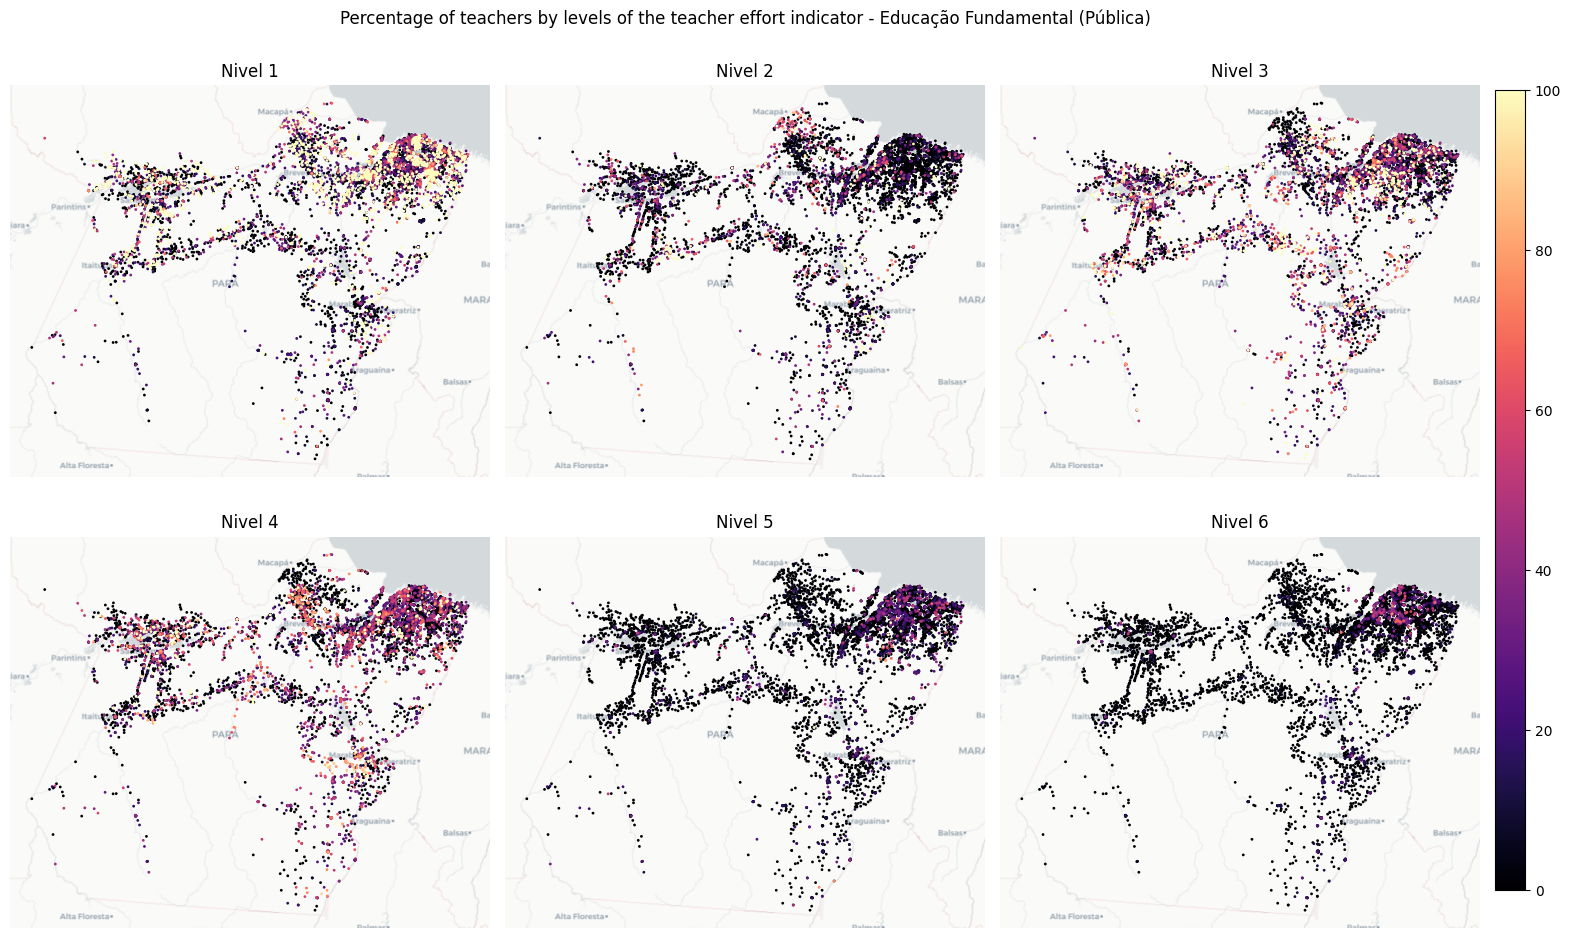

In [181]:
fig, axes = plt.subplots(2, 3, figsize=(15, 10), sharex=True, sharey=True)
fig.suptitle(
    "Percentage of teachers by levels of the teacher effort indicator - Educação Fundamental (Pública)"
)

# Create a single axes for the colorscale
cax = fig.add_axes([1, 0.1, 0.02, 0.8])

for i in range(6):
    ax = axes[i // 3, i % 3]
    filtered_schools.sort_values(f"IED_NIV_{i+1}_FUND").plot(
        f"IED_NIV_{i+1}_FUND", legend=True, ax=ax, cax=cax, markersize=1, cmap="magma"
    )
    ax.set_title(f"Nivel {i+1}")
    ax.set_axis_off()
    ctx.add_basemap(
        ax,
        crs=filtered_schools.crs.to_string(),
        source=ctx.providers.CartoDB.Positron,
        attribution=False,
    )

plt.tight_layout()

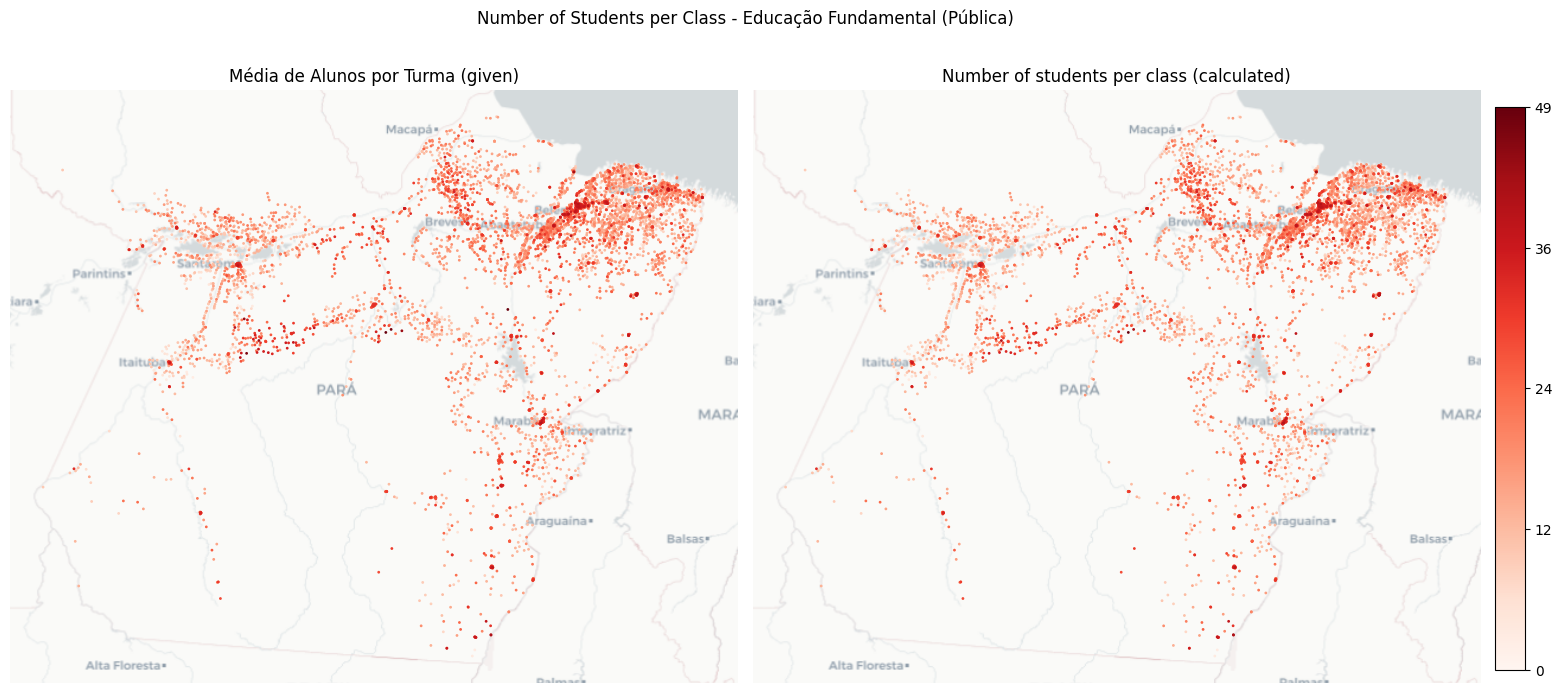

In [182]:
cols = ["MAT_FUND", "students_per_class_FUND"]
label = [
    "Média de Alunos por Turma (given)",
    "Number of students per class (calculated)",
]
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5), sharex=True, sharey=True)
fig.suptitle("Number of Students per Class - Educação Fundamental (Pública)")


# Create a single axes for the colorscale
cax = fig.add_axes([1, 0.1, 0.02, 0.75])

for col, ax in zip(cols, axes):
    filtered_schools.sort_values(col).plot(
        col,
        legend=True,
        ax=ax,
        cax=cax,
        markersize=1,
        cmap="Reds",
        vmin=0,
        vmax=filtered_schools[col].max(),
    )
    cax_ticks = np.linspace(0, filtered_schools[col].max(), 5)
    cax.set_yticks(cax_ticks)
    cax.set_yticklabels([f"{int(tick):,}" for tick in cax_ticks])

    ax.set_title(label[cols.index(col)])
    ax.set_axis_off()
    ctx.add_basemap(
        ax,
        crs=filtered_schools.crs.to_string(),
        source=ctx.providers.CartoDB.Positron,
        attribution=False,
    )

plt.tight_layout()

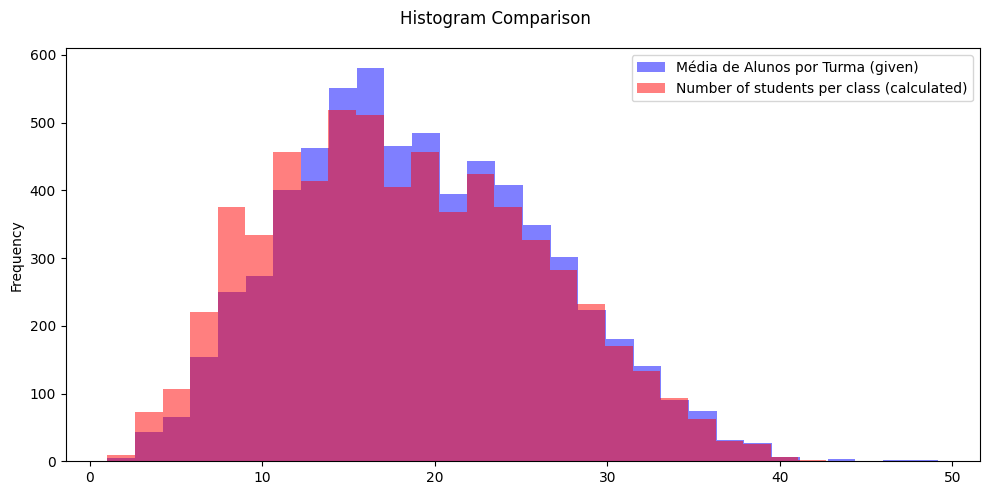

In [191]:
import matplotlib.pyplot as plt

# Create a figure with two subplots
fig, ax = plt.subplots(figsize=(10, 5))

# Plot the histogram of the first variable
ax.hist(
    filtered_schools["MAT_FUND"],
    bins=30,
    color="blue",
    alpha=0.5,
    label="Média de Alunos por Turma (given)",
)
ax.set_ylabel("Frequency")

# Plot the histogram of the second variable
ax.hist(
    filtered_schools["students_per_class_FUND"],
    bins=30,
    color="red",
    alpha=0.5,
    label="Number of students per class (calculated)",
)

# Add a title to the figure
fig.suptitle("Histogram Comparison")

# Add legend to the figure
ax.legend()

# Adjust the spacing between subplots
plt.tight_layout()

# Show the figure
plt.show()

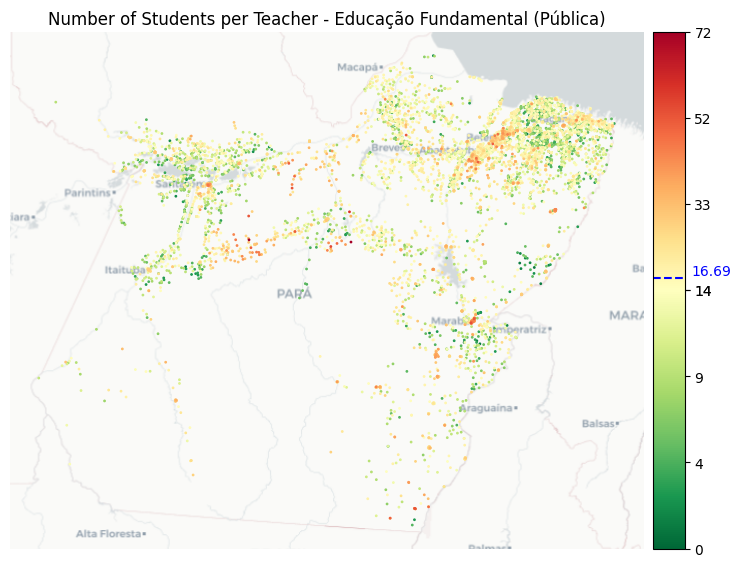

In [238]:
col = "students_per_professor_FUND"
fig, ax = plt.subplots(figsize=(7.5, 7.5))

# Create a single axes for the colorscale
divider = make_axes_locatable(ax)
cax = divider.append_axes("right", size="5%", pad=0.1)


ax = filtered_schools.sort_values(col).plot(
    col,
    legend=True,
    ax=ax,
    cax=cax,
    markersize=1,
    cmap="RdYlGn_r",
    norm=norm,
)

cax_ticks = np.concatenate(
    (np.linspace(0, 14, 4), np.linspace(14, filtered_schools[col].max(), 4))
)
cax.set_yticks(cax_ticks)
cax.set_yticklabels([f"{int(tick):,}" for tick in cax_ticks])

# Add a blue market for the mean value in the colorbar
mean_value = filtered_schools[col].mean()
cax.axhline(mean_value, color="blue", linestyle="--")
cax.text(
    1.2,
    mean_value + 1.5,
    f"{mean_value:.2f}",
    va="center",
    ha="left",
    color="blue",
    bbox=dict(facecolor="none", alpha=0),
)

ax.set_title("Number of Students per Teacher - Educação Fundamental (Pública)")
ax.set_axis_off()
ctx.add_basemap(
    ax,
    crs=filtered_schools.crs.to_string(),
    source=ctx.providers.CartoDB.Positron,
    attribution=False,
)

plt.tight_layout()

In [344]:
# Save the clean filtered schools to a parquet file
final_selected_columns = [
    "code_school",
    "name_school",
    "education_level",
    "address",
    "government_level",
    "date_update",
    "students_per_professor_FUND",
    "students_per_class_FUND",
    "MAT_FUND",
    "IED_NIV_1_FUND",
    "IED_NIV_2_FUND",
    "IED_NIV_3_FUND",
    "IED_NIV_4_FUND",
    "IED_NIV_5_FUND",
    "IED_NIV_6_FUND",
    "QT_MAT_FUND",
    "QT_MAT_FUND_AI",
    "QT_MAT_FUND_AF",
    "QT_DOC_FUND",
    "QT_DOC_FUND_AI",
    "QT_DOC_FUND_AF",
    "QT_TUR_FUND",
    "QT_TUR_FUND_AI",
    "QT_TUR_FUND_AF",
    "geometry",
]
filtered_schools[final_selected_columns].to_parquet(
    "outputs/20240129_para_schools_final.parquet"
)

In [258]:
para_hexs["territory_type"] = para_hexs["territory type"]
para_hexs["territory_type"].replace(
    {
        0: "Rural",
        1: "Urban",
    },
    inplace=True,
)

In [259]:
access_var_labels = {
    "hex": "H3 Hexagon Index",
    "territory type": "Territory Type",
    "population_2020": "Population All Ages",
    "pop_6_14_years_adj": "Population Ages 6-14",
    "income_pc": "Avg Income Per Cápita (R$)",
    "ensino_fundamental": "# of schools - Ensino Fundamental",
    "duration_to_school_min_by_foot": "Travel time to the nearest school by foot",
    "duration_to_school_min_by_foot_cat": "Travel time to the nearest school by foot categories",
    "duration_to_school_min_by_car": "Travel time to the nearest school by car",
    "duration_to_school_min_by_car_cat": "Travel time to the nearest school by car categories",
    "schools_within_15min_travel_time_foot": "# of schools at <15 minutes by foot",
    "schools_within_30min_travel_time_foot": "# of schools at <30 minutes by foot",
    "schools_within_15min_travel_time_car": "# of schools at <15 minutes by car",
    "schools_within_30min_travel_time_car": "# of schools at <30 minutes by car",
}

In [263]:
para_hexs_selected_cols = para_hexs[[*access_var_labels.keys(), "geometry"]]

In [264]:
len(para_hexs_selected_cols.columns)

15

In [327]:
para_hexs_selected_cols.select_dtypes(include="object").columns

Index(['hex', 'territory type'], dtype='object')

In [304]:
agg = {
    col: "sum"
    for col in para_hexs_selected_cols.select_dtypes(include="number").columns
}
agg["income_pc"] = "mean"
agg["duration_to_school_min_by_foot"] = "mean"
agg["duration_to_school_min_by_car"] = "mean"

In [320]:
para_hexs_selected_cols_res7 = up.geom.resolution_downsampling(
    para_hexs_selected_cols, "hex", 4, agg=agg
)

In [321]:
para_hexs_selected_cols_res7.head()

,hex_4,population_2020,pop_6_14_years_adj,income_pc,ensino_fundamental,duration_to_school_min_by_foot,duration_to_school_min_by_car,schools_within_15min_travel_time_foot,schools_within_30min_travel_time_foot,schools_within_15min_travel_time_car,schools_within_30min_travel_time_car,geometry
0,845f049ffffffff,788.666242,38.383675,74.051771,0.0,81.338333,81.338333,0,0,0,0,"POLYGON ((-55.95308 2.06821, -55.76442 2.22800..."
1,845f201ffffffff,23.119211,4.345537,52.867123,0.0,994.993333,994.993333,0,0,0,0,"POLYGON ((-56.82128 0.78516, -56.63353 0.94410..."
2,845f203ffffffff,23.119211,4.345537,52.867123,0.0,994.993333,994.993333,0,0,0,0,"POLYGON ((-57.08024 1.11256, -56.89297 1.27144..."
3,845f205ffffffff,5.779803,1.086384,52.867123,0.0,40.669167,40.669167,0,0,0,0,"POLYGON ((-56.40941 0.85956, -56.22107 1.01880..."
4,845f207ffffffff,11.559606,2.172769,52.867123,0.0,994.993333,994.993333,0,0,0,0,"POLYGON ((-56.66951 1.18744, -56.48165 1.34660..."


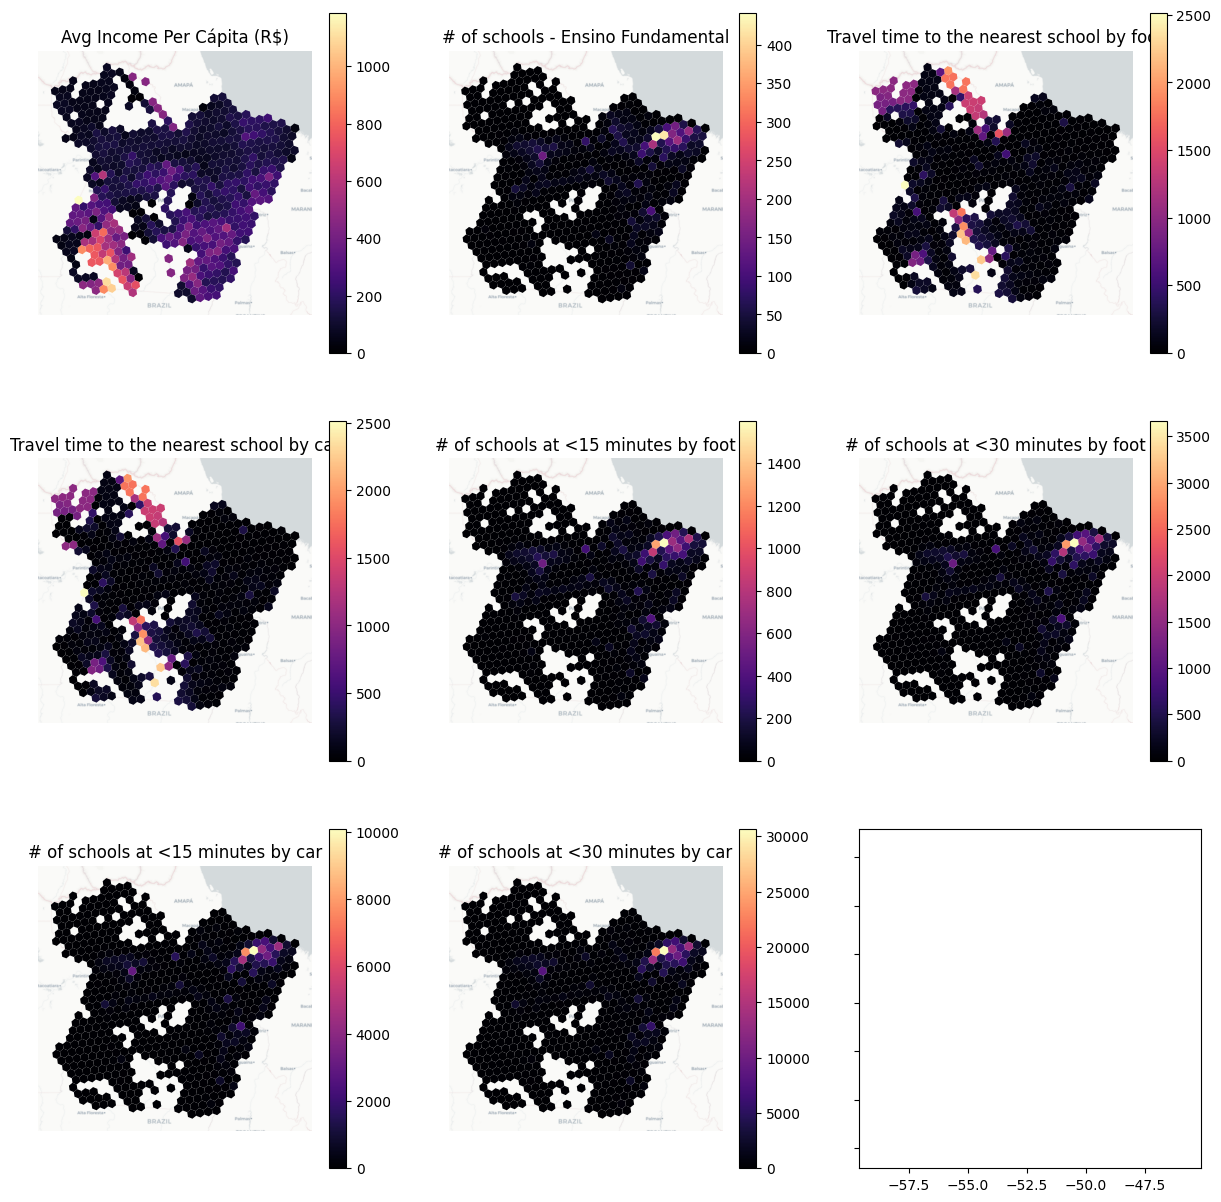

In [326]:
# Create a plot for each variable
fig, axes = plt.subplots(
    nrows=agg.keys().__len__() // 3, ncols=3, figsize=(15, 15), sharex=True, sharey=True
)

for i, col in enumerate([*agg.keys()][2:]):
    ax = axes[i // 3, i % 3]
    if i % 2 == 0:
        para_hexs_selected_cols_res7.plot(
            col, legend=True, ax=ax, cmap="magma", edgecolor="none", linewidth=0.0
        )
    else:
        para_hexs_selected_cols_res7.plot(
            col,
            legend=True,
            ax=ax,
            cmap="magma",
        )
    ax.set_title(access_var_labels[col])
    ax.set_axis_off()
    ctx.add_basemap(
        ax,
        crs=para_hexs_selected_cols.crs.to_string(),
        source=ctx.providers.CartoDB.Positron,
        attribution=False,
    )

In [323]:
access_var_labels = {
    "hex": "H3 Hexagon Index",
    "territory type": "Territory Type",
    "population_2020": "Population All Ages",
    "pop_6_14_years_adj": "Population Ages 6-14",
    "income_pc": "Avg Income Per Cápita (R$)",
    "ensino_fundamental": "# of schools - Ensino Fundamental",
    "duration_to_school_min_by_foot": "Travel time to the nearest school by foot",
    "duration_to_school_min_by_foot_cat": "Travel time to the nearest school by foot categories",
    "duration_to_school_min_by_car": "Travel time to the nearest school by car",
    "duration_to_school_min_by_car_cat": "Travel time to the nearest school by car categories",
    "schools_within_15min_travel_time_foot": "# of schools at <15 minutes by foot",
    "schools_within_30min_travel_time_foot": "# of schools at <30 minutes by foot",
    "schools_within_15min_travel_time_car": "# of schools at <15 minutes by car",
    "schools_within_30min_travel_time_car": "# of schools at <30 minutes by car",
}

In [328]:
# Aggregate school indicators by hexagon
schools_col = [
    "students_per_professor_FUND",
    "students_per_class_FUND",
    "MAT_FUND",
    "IED_NIV_1_FUND",
    "IED_NIV_2_FUND",
    "IED_NIV_3_FUND",
    "IED_NIV_4_FUND",
    "IED_NIV_5_FUND",
    "IED_NIV_6_FUND",
]
para_hexs_schools_cols = up.geom.merge_shape_hex(
    hexs=para_hexs_selected_cols,
    shape=filtered_schools,
    agg={col: "mean" for col in schools_col},
)

In [339]:
para_hexs_schools_cols.geometry

0          POLYGON ((-48.93853 -3.05994, -48.93450 -3.056...
25         POLYGON ((-49.41769 -4.35284, -49.41367 -4.349...
35         POLYGON ((-51.65029 -3.40602, -51.64630 -3.402...
40         POLYGON ((-49.35004 -7.87575, -49.34600 -7.872...
46         POLYGON ((-52.86212 -1.66023, -52.85817 -1.656...
                                 ...                        
1501100    POLYGON ((-49.65169 0.14779, -49.64769 0.15111...
1501109    POLYGON ((-49.62455 0.17612, -49.62056 0.17943...
1501113    POLYGON ((-49.65415 0.16310, -49.65016 0.16642...
1501116    POLYGON ((-49.63406 0.15085, -49.63007 0.15416...
1501119    POLYGON ((-49.63970 0.15774, -49.63571 0.16106...
Name: geometry, Length: 132361, dtype: geometry

In [331]:
para_hexs_schools_cols_res4 = up.geom.resolution_downsampling(
    para_hexs_schools_cols, "hex", 4, agg={col: "mean" for col in schools_col}
)

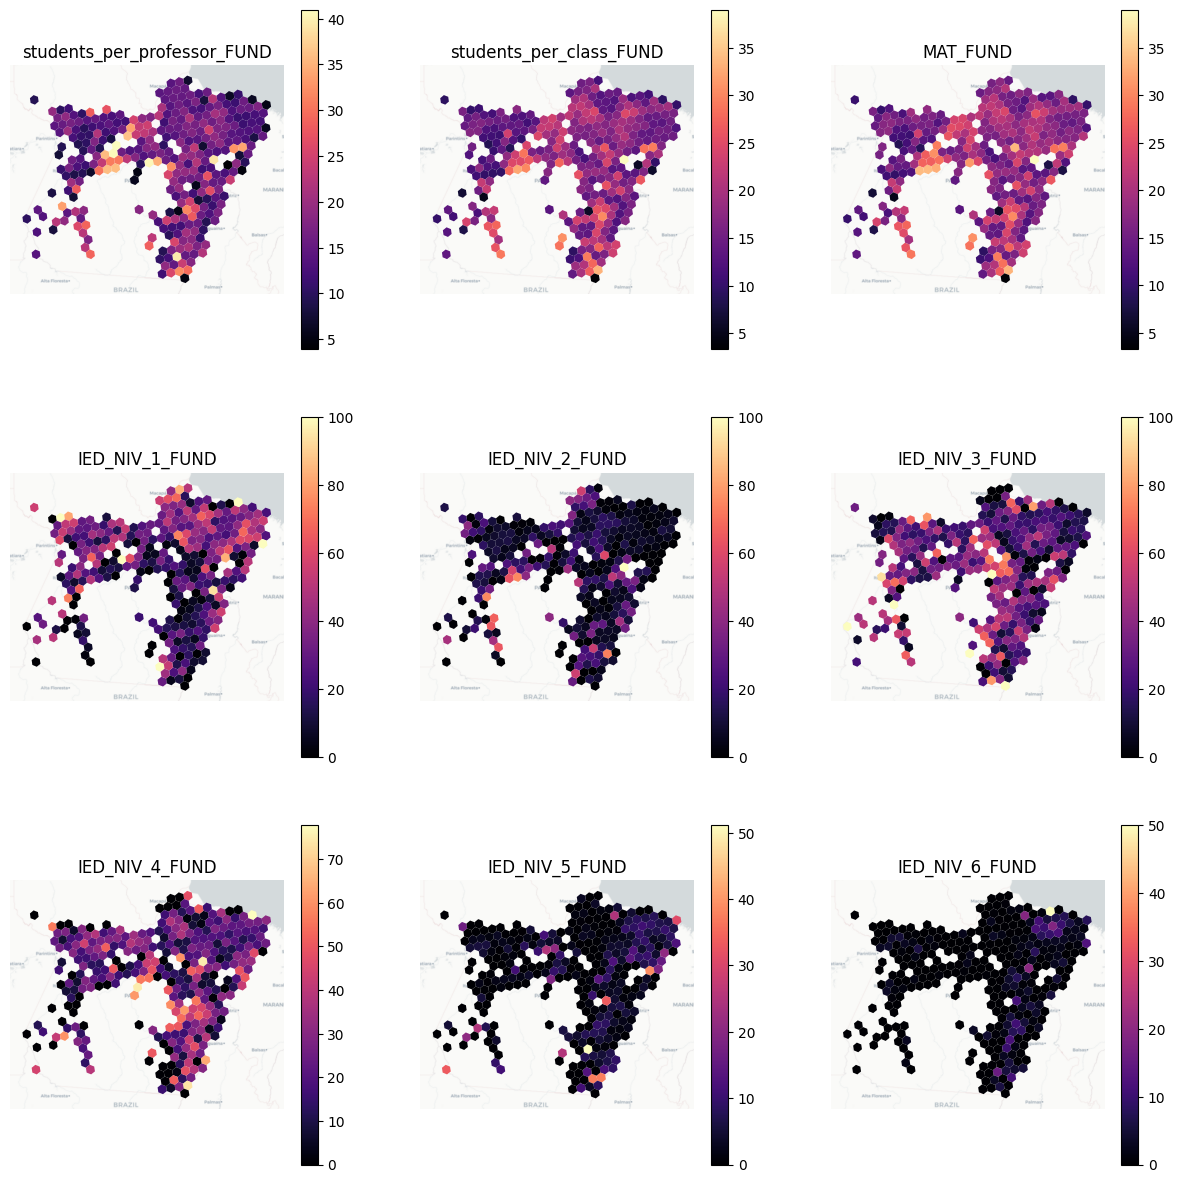

In [332]:
# Create a plot for each variable
fig, axes = plt.subplots(
    nrows=len(schools_col) // 3, ncols=3, figsize=(15, 15), sharex=True, sharey=True
)

for i, col in enumerate(schools_col):
    ax = axes[i // 3, i % 3]
    para_hexs_schools_cols_res4.plot(
        col,
        legend=True,
        ax=ax,
        cmap="magma",
    )
    ax.set_title(col)
    ax.set_axis_off()
    ctx.add_basemap(
        ax,
        crs=para_hexs_selected_cols.crs.to_string(),
        source=ctx.providers.CartoDB.Positron,
        attribution=False,
    )

In [333]:
capacity_var_labels = {
    "students_per_professor_FUND": "Average # Students per Teacher",
    "students_per_class_FUND": "Average # Students per Class (calculated)",
    "MAT_FUND": "Average # Students per Class (given)",
    "IED_NIV_1_FUND": "Perc. Teachers with effort indicator - Level 1",
    "IED_NIV_2_FUND": "Perc. Teachers with effort indicator - Level 2",
    "IED_NIV_3_FUND": "Perc. Teachers with effort indicator - Level 3",
    "IED_NIV_4_FUND": "Perc. Teachers with effort indicator - Level 4",
    "IED_NIV_5_FUND": "Perc. Teachers with effort indicator - Level 5",
    "IED_NIV_6_FUND": "Perc. Teachers with effort indicator - Level 6",
}

In [341]:
# Save dataset as parquet file
para_hexs_schools_cols.to_parquet(
    "outputs/20240129_para_hexs_with_accessibility_capacity_vars.parquet"
)

In [340]:
para_hexs_schools_cols.geometry

0          POLYGON ((-48.93853 -3.05994, -48.93450 -3.056...
25         POLYGON ((-49.41769 -4.35284, -49.41367 -4.349...
35         POLYGON ((-51.65029 -3.40602, -51.64630 -3.402...
40         POLYGON ((-49.35004 -7.87575, -49.34600 -7.872...
46         POLYGON ((-52.86212 -1.66023, -52.85817 -1.656...
                                 ...                        
1501100    POLYGON ((-49.65169 0.14779, -49.64769 0.15111...
1501109    POLYGON ((-49.62455 0.17612, -49.62056 0.17943...
1501113    POLYGON ((-49.65415 0.16310, -49.65016 0.16642...
1501116    POLYGON ((-49.63406 0.15085, -49.63007 0.15416...
1501119    POLYGON ((-49.63970 0.15774, -49.63571 0.16106...
Name: geometry, Length: 132361, dtype: geometry